# In this code a time series problem has been transformed into a supervised learning problem with velocities of 8 previous input time steps and output of 5 next time steps.
# The data of only a unique vehicle ID has been fetched and used for the model training and predictions.
# LSTM model has been trained, predictions were made over the test dataset and has been plotted against the true values.
# An another approach for prediction and comparision over the test dataset has been tried.
# The predictions over a smaller range for the subset (randomly selected) is also shown.
# The entire prediction values of time t, t+1, t+2 has beem tried to compare in a plot.

In [99]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [100]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.14.0


In [102]:
# Load the CSV file
df = pd.read_csv('../Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [103]:
velocity_dataset.shape

(9455901, 6)

In [104]:
velocity_dataset.head()

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6451203.729,1873252.549,23.31,2.05,1118848075000,515
1,6451203.729,1873252.549,23.31,2.05,1118848075000,515
2,6042814.264,2133542.012,26.54,-0.76,1113437421700,2224
3,6452425.122,1872172.475,37.52,11.20,1118847624800,2127
4,6452347.673,1872258.452,41.99,0.10,1118848324700,1033


In [105]:
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [106]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [107]:
velocity_dataset_sorted['Global_Time'].iloc[0]

1113433136300

In [108]:
# Count the number of unique vehicle IDs
unique_vehicle_ids = velocity_dataset['Vehicle_ID'].nunique()
print(f"Number of unique vehicle IDs: {unique_vehicle_ids}")

# Count how many rows of data each vehicle ID has
vehicle_counts = velocity_dataset['Vehicle_ID'].value_counts()

# Display the counts of rows for each vehicle ID
print("\nNumber of rows for each vehicle ID:")
print(vehicle_counts)

Number of unique vehicle IDs: 3233

Number of rows for each vehicle ID:
396     8311
705     7508
567     7441
601     7253
468     7206
        ... 
2897     167
2806      78
2815      70
2810      66
2781      60
Name: Vehicle_ID, Length: 3233, dtype: int64


In [109]:
# Access the count for a particular vehicle ID
specific_vehicle_id = 396
num_rows = vehicle_counts[specific_vehicle_id]

print(f"The vehicle ID '{specific_vehicle_id}' has {num_rows} rows of data.")

single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == specific_vehicle_id]

The vehicle ID '396' has 8311 rows of data.


In [110]:
# there is some problem in the values of global time
t_1st = single_vehicle_data['Global_Time'].iloc[0]
t_end = single_vehicle_data['Global_Time'].iloc[-1]
velocity_time_distribution = (t_end - t_1st)/num_rows
print(t_1st)
print(t_end)
print(f"The ratio of overall time upon the number of velocities: {velocity_time_distribution:.2f}")

1163281700
1118937063800
The ratio of overall time upon the number of velocities: 134493295.88


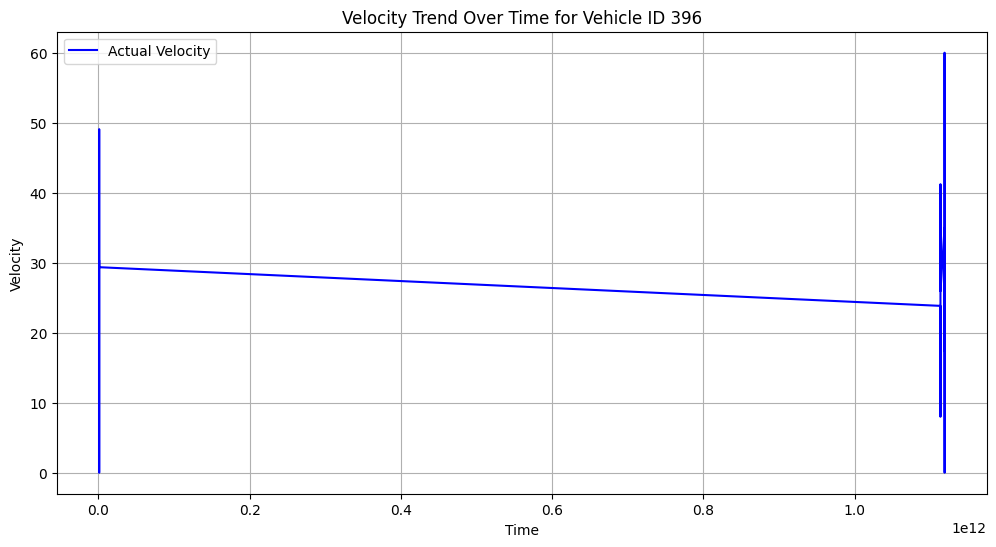

In [111]:
# Assuming 'single_vehicle_data' contains the data for a specific vehicle ID
# Extracting the time and velocity columns
time = single_vehicle_data['Global_Time'].values
velocity = single_vehicle_data['v_Vel'].values

# Plot the velocity trend over time
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend Over Time for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()

In [112]:
# # Plot velocity over time
# plt.figure(figsize=(12, 6))
# plt.plot(velocity_dataset_sorted['Global_Time'], velocity_dataset_sorted['v_Vel'], label='Velocity')
# plt.xlabel('Global Time (ms)')
# plt.ylabel('Velocity (v_vel)')
# plt.title('Velocity Evolution Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

In [113]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Ensure data is in 2D format (n_samples, n_features)
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names += [f'var1(t-{i})']
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        if i == 0:
            names += [f'var1(t)']
        else:
            names += [f'var1(t+{i})']
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [114]:
# Extract the velocity column
velocities = single_vehicle_data['v_Vel'].values

# Convert the velocity time series into a supervised learning problem
n_in = 8  # Number of previous time steps to use as input
n_out = 5  # Number of future time steps to predict (3 step ahead)
supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)

# Time Steps:   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1   t  t+1  t+2  t+3  t+4
# Values:      [ x ,  x ,  x ,  x ,  x ,  x ,  x ,  x ] -> [ y ,  y ,  y,  y,  y]

# Print the first few rows to verify the transformation
print(velocities)
print(supervised_data.head())

[30.25 30.25 30.25 ... 17.45 17.45 17.45]
    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
8       30.25      30.25      30.25      30.25      30.25      30.25   
9       30.25      30.25      30.25      30.25      30.25      30.24   
10      30.25      30.25      30.25      30.25      30.24      30.24   
11      30.25      30.25      30.25      30.24      30.24      30.24   
12      30.25      30.25      30.24      30.24      30.24      30.24   

    var1(t-2)  var1(t-1)  var1(t)  var1(t+1)  var1(t+2)  var1(t+3)  var1(t+4)  
8       30.24      30.24    30.24      30.24      30.23      30.23      30.23  
9       30.24      30.24    30.24      30.23      30.23      30.23      30.23  
10      30.24      30.24    30.23      30.23      30.23      30.23      30.23  
11      30.24      30.23    30.23      30.23      30.23      30.23      30.23  
12      30.23      30.23    30.23      30.23      30.23      30.23      30.22  


In [115]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(supervised_data) * 0.7)
n_validation = int(len(supervised_data) * 0.15)

train_data = supervised_data[:n_train]
validation_data = supervised_data[n_train:n_train + n_validation]
test_data = supervised_data[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
X_train, y_train = train_data.iloc[:, :-n_out].values, train_data.iloc[:, -n_out:].values
X_validation, y_validation = validation_data.iloc[:, :-n_out].values, validation_data.iloc[:, -n_out:].values
X_test, y_test = test_data.iloc[:, :-n_out].values, test_data.iloc[:, -n_out:].values

# # Print the shapes of the splits to verify
# print("Training features shape:", X_train)
# print("Training labels shape:", y_train)
# print("Validation features shape:", X_validation)
# print("Validation labels shape:", y_validation)
# print("Test features shape:", X_test)
# print("Test labels shape:", y_test)

In [116]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], n_in, 1))
X_validation = X_validation.reshape((X_validation.shape[0], n_in, 1))
X_test = X_test.reshape((X_test.shape[0], n_in, 1))

In [117]:
print(len(y_test))
print(X_test.shape)
print(y_test.shape)

1246
(1246, 8, 1)
(1246, 5)


In [125]:
# Define the LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(n_out)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                         validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")


Epoch 1/50
182/182 [==============================] - 13s 47ms/step - loss: 113.4543 - val_loss: 13.9287
Epoch 2/50
182/182 [==============================] - 8s 44ms/step - loss: 59.1272 - val_loss: 13.2314
Epoch 3/50
182/182 [==============================] - 8s 44ms/step - loss: 58.2836 - val_loss: 9.7606
Epoch 4/50
182/182 [==============================] - 8s 45ms/step - loss: 57.4634 - val_loss: 9.8635
Epoch 5/50
182/182 [==============================] - 8s 43ms/step - loss: 57.0272 - val_loss: 8.6895
Epoch 6/50
182/182 [==============================] - 8s 43ms/step - loss: 56.4291 - val_loss: 7.4802
Epoch 7/50
182/182 [==============================] - 8s 41ms/step - loss: 56.0310 - val_loss: 9.8639
Epoch 8/50
182/182 [==============================] - 8s 42ms/step - loss: 54.6818 - val_loss: 13.9532
Epoch 9/50
182/182 [==============================] - 8s 42ms/step - loss: 53.9215 - val_loss: 7.6011
Epoch 10/50
182/182 [==============================] - 8s 43ms/step - loss: 5

In [126]:
# # Test predictions over the entire test dataset (5 output at a time)
# predictions = []

# # Loop through each sample in the test dataset
# for i in range(len(X_test)):
#     # Extract the current sequence (8 time steps)
#     current_sequence = X_test[i]  # Get the ith row
    
#     # Reshape it to the correct shape for prediction: (1, 8, 1)
#     current_sequence = current_sequence.reshape(1, current_sequence.shape[0], 1)
    
#     # Debugging print statements
#     print(f"i = {i}, current_sequence shape = {current_sequence.shape}")
    
#     # Predict the next velocity based on the current sequence
#     next_5_velocities = lstm_model.predict(current_sequence, verbose=0) # verbose=0 : Silent mode - no output during training
    
#     # Append the predicted velocity to the predictions list
#     predictions.append(next_5_velocities[0, 0])
    
#     # Shift by 5 time steps
#     i += 5

# # Print the predicted velocities for the test dataset
# print("Predicted velocities for the test dataset are:", predictions)

In [127]:
# Initialize arrays to hold the combined input + predicted values and true values
all_predicted_values = []
all_true_values = []

# Loop through the test set, making predictions and shifting by 5 steps
for i in range(0, len(X_test), 5):  # Shift by 5 steps
    # Extract the current sequence from X_test (8 input values)
    current_sequence = X_test[i].flatten()  # (8,)
    
    # Make 5 predictions based on this sequence
    predicted_velocities = lstm_model.predict(current_sequence.reshape(1, 8, 1), verbose=0).flatten()
    
    # Append the 8 inputs followed by 5 predicted outputs to the prediction array
    all_predicted_values.extend(current_sequence)  # First the 8 inputs
    all_predicted_values.extend(predicted_velocities)  # Then the 5 predicted outputs
    
    # Append the true 8 inputs followed by 5 actual outputs from y_test
    true_outputs = y_test[i].flatten()  # Get the 5 true outputs from y_test
    all_true_values.extend(current_sequence)  # First the 8 inputs
    all_true_values.extend(true_outputs)  # Then the 5 true outputs

# Now `all_predicted_values` and `all_true_values` are 1D arrays combining inputs and outputs
print(f"Predicted Values Length: {len(all_predicted_values)}, True Values Length: {len(all_true_values)}")


Predicted Values Length: 3250, True Values Length: 3250


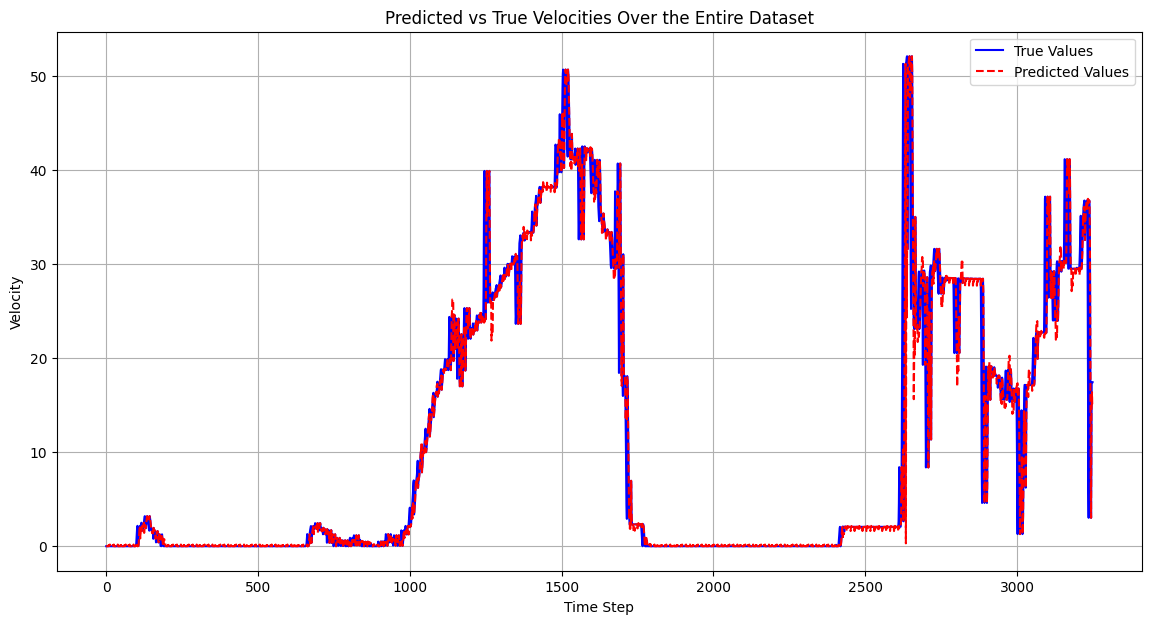

In [128]:
# Create time indices for the entire dataset
time_indices = np.arange(len(all_predicted_values))

# Plot predicted values and true values across the entire dataset
plt.figure(figsize=(14, 7))

# Plot true values (input + output)
plt.plot(time_indices, all_true_values, label='True Values', color='blue')

# Plot predicted values (input + output)
plt.plot(time_indices, all_predicted_values, label='Predicted Values', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Predicted vs True Velocities Over the Entire Dataset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

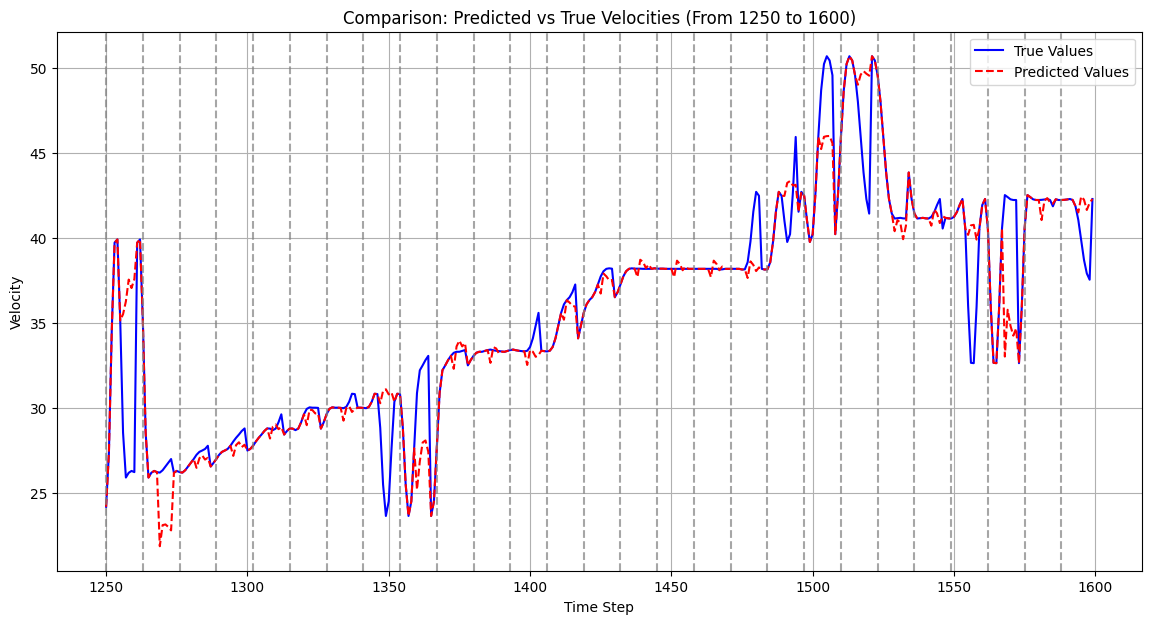

In [129]:
# Define the range for the subset
start_idx = 1250
end_idx = 1600

# Subset of time indices, predicted values, and true values for the range 1000 to 1500
time_indices_subset = np.arange(start_idx, end_idx)
true_values_subset = all_true_values[start_idx:end_idx]
predicted_values_subset = all_predicted_values[start_idx:end_idx]

# Plotting the subset of predicted vs true values
plt.figure(figsize=(14, 7))

# Plot true values (input + output)
plt.plot(time_indices_subset, true_values_subset, label='True Values', color='blue')

# Plot predicted values (input + output)
plt.plot(time_indices_subset, predicted_values_subset, label='Predicted Values', color='red', linestyle='--')

# Add vertical lines to mark the sections for each prediction interval (8 inputs + 5 outputs)
for i in range(start_idx, end_idx, 13):  # 8 inputs + 5 outputs = 13 total time steps
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title(f'Comparison: Predicted vs True Velocities (From {start_idx} to {end_idx})')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

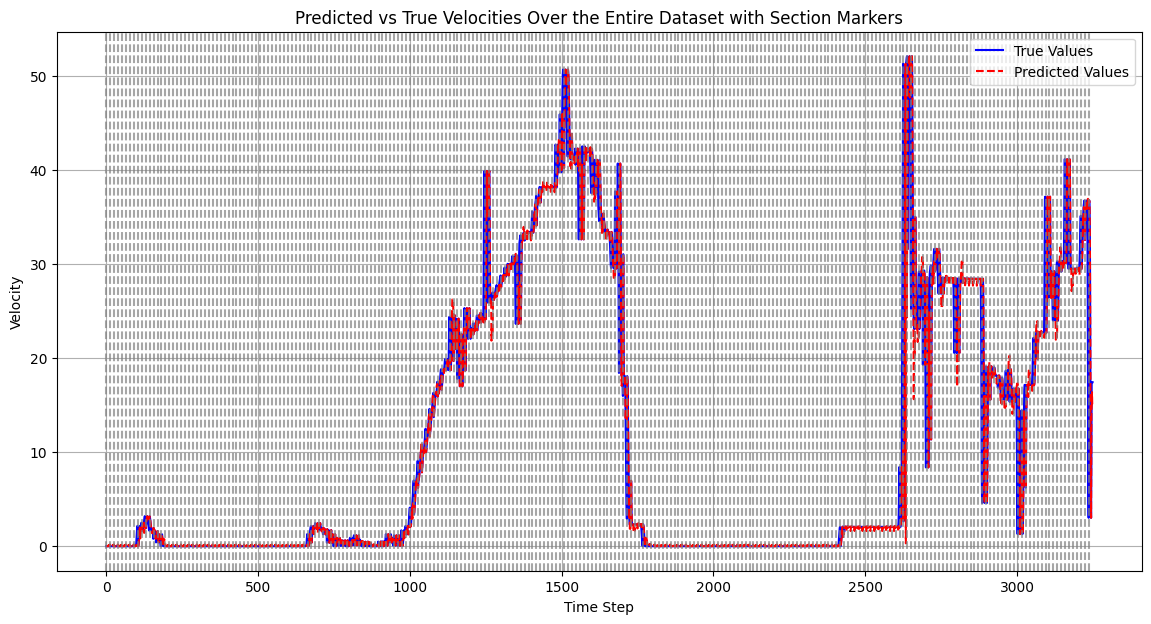

In [130]:
import matplotlib.pyplot as plt

# Create time indices for the entire dataset
time_indices = np.arange(len(all_predicted_values))

# Plot predicted values and true values across the entire dataset
plt.figure(figsize=(14, 7))

# Plot true values (input + output)
plt.plot(time_indices, all_true_values, label='True Values', color='blue')

# Plot predicted values (input + output)
plt.plot(time_indices, all_predicted_values, label='Predicted Values', color='red', linestyle='--')

# Add vertical lines to mark the sections for each prediction interval (8 inputs + 5 outputs)
for i in range(0, len(time_indices), 13):  # 8 inputs + 5 outputs = 13 total time steps
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Predicted vs True Velocities Over the Entire Dataset with Section Markers')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [124]:
test_predicted_values = lstm_model.predict(X_test)

# Extract the velocity predictions for t, t+1, t+2
predicted_velocities_t = test_predicted_values[:, 0]  # Prediction at time t
predicted_velocities_t1 = test_predicted_values[:, 1]  # Prediction at time t+1
predicted_velocities_t2 = test_predicted_values[:, 2]  # Prediction at time t+2

# The true values for comparison
true_velocities_t = y_test[:, 0]  # Actual value at time t
true_velocities_t1 = y_test[:, 1]  # Actual value at time t+1
true_velocities_t2 = y_test[:, 2]  # Actual value at time t+2

rmse_t = np.sqrt(mean_squared_error(true_velocities_t, predicted_velocities_t))
rmse_t1 = np.sqrt(mean_squared_error(true_velocities_t1, predicted_velocities_t1))
rmse_t2 = np.sqrt(mean_squared_error(true_velocities_t2, predicted_velocities_t2))

print(f"RMSE at time t: {rmse_t:.4f}")
print(f"RMSE at time t+1: {rmse_t1:.4f}")
print(f"RMSE at time t+2: {rmse_t2:.4f}")

39/39 [==============================] - 0s 7ms/step
RMSE at time t: 2.6728
RMSE at time t+1: 3.2079
RMSE at time t+2: 3.9279


In [ ]:
rmse_overall = np.sqrt(mean_squared_error(y_test.flatten(), test_predicted_values.flatten()))
print(f"Overall RMSE for t, t+1, t+2: {rmse_overall:.4f}")

In [ ]:
# # Visualising one at a time
# # Create time indices for the test dataset
# time_indices = np.arange(len(true_velocities_t))

# # Plotting the true and predicted velocities for t, t+1, and t+2
# plt.figure(figsize=(14, 8))

# # Plot for time t
# plt.subplot(3, 1, 1)
# plt.plot(time_indices, true_velocities_t, label='True Velocity at t', color='blue')
# plt.plot(time_indices, predicted_velocities_t, label='Predicted Velocity at t', color='red', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.title(f'Velocity at time t (RMSE: {rmse_t:.4f})')
# plt.legend()

# # Plot for time t+1
# plt.subplot(3, 1, 2)
# plt.plot(time_indices, true_velocities_t1, label='True Velocity at t+1', color='blue')
# plt.plot(time_indices, predicted_velocities_t1, label='Predicted Velocity at t+1', color='red', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.title(f'Velocity at time t+1 (RMSE: {rmse_t1:.4f})')
# plt.legend()

# # Plot for time t+2
# plt.subplot(3, 1, 3)
# plt.plot(time_indices, true_velocities_t2, label='True Velocity at t+2', color='blue')
# plt.plot(time_indices, predicted_velocities_t2, label='Predicted Velocity at t+2', color='red', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.title(f'Velocity at time t+2 (RMSE: {rmse_t2:.4f})')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# Visualising all at once
# Create time indices for the test dataset
time_indices = np.arange(len(true_velocities_t))

# Plotting the true and predicted velocities
plt.figure(figsize=(14, 8))

# Plot for the true velocity at time t
plt.plot(time_indices, true_velocities_t, label='True Velocity', color='blue', linewidth=2)

# Plot for the predicted velocity at time t
plt.plot(time_indices, predicted_velocities_t, label='Predicted Velocity at t', color='red', linestyle='--')

# Plot for the predicted velocity at time t+1
plt.plot(time_indices, predicted_velocities_t1, label='Predicted Velocity at t+1', color='green', linestyle='--')

# Plot for the predicted velocity at time t+2
plt.plot(time_indices, predicted_velocities_t2, label='Predicted Velocity at t+2', color='orange', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('True and Predicted Velocities Over Time')
plt.legend()

# Show plot
plt.show()

In [ ]:
# Use the last known sequence from the test set for prediction
last_sequence = X_test[-1]

# Number of future steps to predict
n_steps = 6
predictions = []

for _ in range(n_steps):
    # Predict the next velocity
    next_velocity = lstm_model.predict(last_sequence.reshape(1, last_sequence.shape[0], 1), verbose=0)
    
    # Append the predicted velocity to the predictions list
    predictions.append(next_velocity[0, 0])
    
    # Update the sequence: remove the oldest velocity and add the predicted one
    last_sequence = np.append(last_sequence[1:], next_velocity[0, 0]).reshape(-1, 1)

# Print the predicted velocities for the next 6 steps
print("Predicted velocities for the next 6 time steps:", predictions)

# Convert the predictions into a DataFrame for easier handling
predicted_df = pd.DataFrame(predictions, columns=['Predicted Velocity'])

print(predicted_df)

In [ ]:
# Ensure the true_velocities is flattened correctly
true_velocities = y_test.flatten()

# Number of actual data points for plotting
n_true_points = len(true_velocities)

# Adjust the time indices to match the length of the true velocities
time_indices = np.arange(len(single_vehicle_data) - n_true_points, len(single_vehicle_data))

# Ensure both time_indices and true_velocities have the same length
if len(time_indices) != len(true_velocities):
    raise ValueError(f"Length of time_indices ({len(time_indices)}) does not match length of true_velocities ({len(true_velocities)}).")

# Create DataFrame for actual values (trim the time indices to match true_velocities)
actual_df = pd.DataFrame({
    'Time': time_indices,
    'Actual Velocity': true_velocities
})

# Create time indices for the predictions
predicted_time_indices = np.arange(len(single_vehicle_data), len(single_vehicle_data) + len(predictions))

# Create DataFrame for predicted values
predicted_df = pd.DataFrame({
    'Time': predicted_time_indices,
    'Predicted Velocity': predictions
})

# Plotting the actual and predicted velocities
plt.figure(figsize=(12, 6))

# Plot the actual velocities
plt.plot(actual_df['Time'], actual_df['Actual Velocity'], label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(predicted_df['Time'], predicted_df['Predicted Velocity'], label='Predicted Velocity (Next 6 Steps)', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()